In [1]:
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd

# Define the date range
start_date = "2012-01-01"
end_date = "2024-12-31"

# Fetch FHFA House Price Index (Housing Prices) from FRED
print("Fetching FHFA House Price Index...")
fhfa_data = web.DataReader("HPIPONM226S", "fred", start_date, end_date)

# Fetch Real GDP data from FRED
print("Fetching Real GDP data...")
gdp_data = web.DataReader("GDPC1", "fred", start_date, end_date)

# Resample data to quarterly frequency if needed (both are quarterly by default)
fhfa_data = fhfa_data.resample('QE').mean()
gdp_data = gdp_data.resample('QE').mean()

# Combine the datasets
combined_data = pd.concat([fhfa_data, gdp_data], axis=1)
combined_data.columns = ["FHFA_House_Price_Index", "Real_GDP"]
combined_data.dropna(inplace=True)

print("Combined Dataset:\n", combined_data.head())

# Save the dataset to a CSV file
combined_data.to_csv("housing_gdp_data.csv")
print("Data saved to 'housing_gdp_data.csv'")

Fetching FHFA House Price Index...
Fetching Real GDP data...
Combined Dataset:
             FHFA_House_Price_Index   Real_GDP
DATE                                         
2012-03-31              178.793333  17367.010
2012-06-30              181.813333  17444.525
2012-09-30              184.130000  17469.650
2012-12-31              186.803333  17489.852
2013-03-31              190.553333  17662.400
Data saved to 'housing_gdp_data.csv'


Summary Statistics:
        FHFA_House_Price_Index      Real_GDP
count               51.000000     51.000000
mean               277.249935  20067.761431
std                 78.778291   1775.140485
min                178.793333  17367.010000
25%                212.930000  18724.432000
50%                255.226667  20044.077000
75%                339.628333  21480.213000
max                427.820000  23386.733000


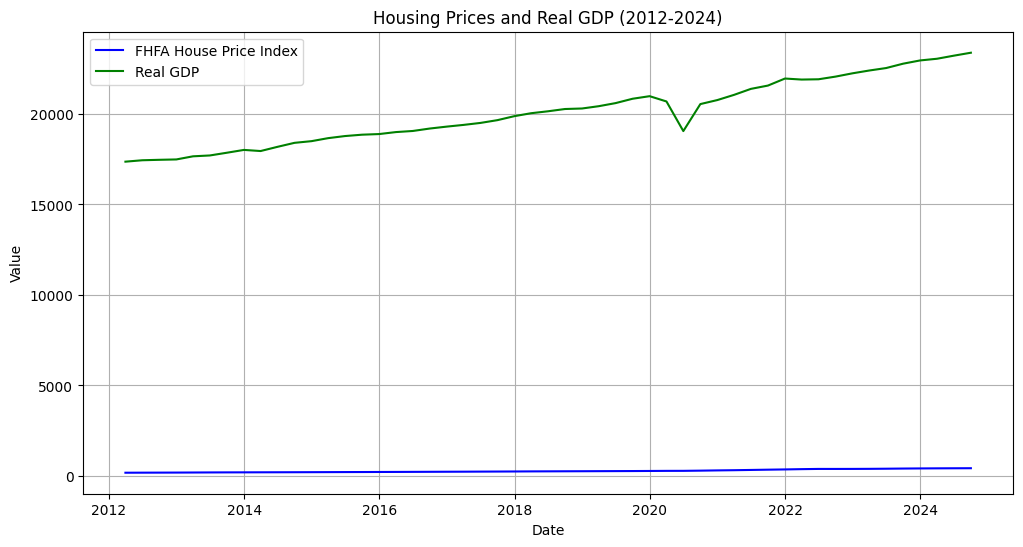

In [2]:
import matplotlib.pyplot as plt

# Load the dataset (if not already in memory)
data = pd.read_csv("housing_gdp_data.csv", parse_dates=["DATE"], index_col="DATE")

# Step 1: Summary statistics
print("Summary Statistics:\n", data.describe())

# Step 2: Plot Housing Prices and Real GDP
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["FHFA_House_Price_Index"], label="FHFA House Price Index", color="blue")
plt.plot(data.index, data["Real_GDP"], label="Real GDP", color="green")
plt.title("Housing Prices and Real GDP (2012-2024)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

In [3]:
import statsmodels.api as sm

# Define the dependent (Y) and independent (X) variables
Y = data["Real_GDP"]
X = data["FHFA_House_Price_Index"]
X = sm.add_constant(X)  # Add a constant for the intercept

# Perform OLS Regression
print("Performing OLS Regression...")
model = sm.OLS(Y, X).fit()

# Display the summary results
print(model.summary())

Performing OLS Regression...
                            OLS Regression Results                            
Dep. Variable:               Real_GDP   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     760.6
Date:                Wed, 18 Dec 2024   Prob (F-statistic):           1.68e-31
Time:                        16:32:50   Log-Likelihood:                -381.90
No. Observations:                  51   AIC:                             767.8
Df Residuals:                      49   BIC:                             771.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [4]:
# Standardize the independent variable
data['FHFA_House_Price_Index_Standardized'] = (data['FHFA_House_Price_Index'] - data['FHFA_House_Price_Index'].mean()) / data['FHFA_House_Price_Index'].std()

# Define the dependent (Y) and independent (X) variables
Y = data["Real_GDP"]
X = data["FHFA_House_Price_Index_Standardized"]
X = sm.add_constant(X)  # Add a constant for the intercept

# Perform OLS Regression
print("Performing OLS Regression with Standardized Data...")
model_standardized = sm.OLS(Y, X).fit()

# Display the summary results
print(model_standardized.summary())

Performing OLS Regression with Standardized Data...
                            OLS Regression Results                            
Dep. Variable:               Real_GDP   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     760.6
Date:                Wed, 18 Dec 2024   Prob (F-statistic):           1.68e-31
Time:                        16:32:59   Log-Likelihood:                -381.90
No. Observations:                  51   AIC:                             767.8
Df Residuals:                      49   BIC:                             771.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [5]:
import statsmodels.stats.api as sms

# Extract residuals
residuals = model_standardized.resid

# 1. Normality Test: Jarque-Bera
jb_test = sms.jarque_bera(residuals)
print("\nJarque-Bera Test for Normality:")
print(f"JB Statistic: {jb_test[0]}, p-value: {jb_test[1]}")


Jarque-Bera Test for Normality:
JB Statistic: 0.09417503079664892, p-value: 0.9540039039052796


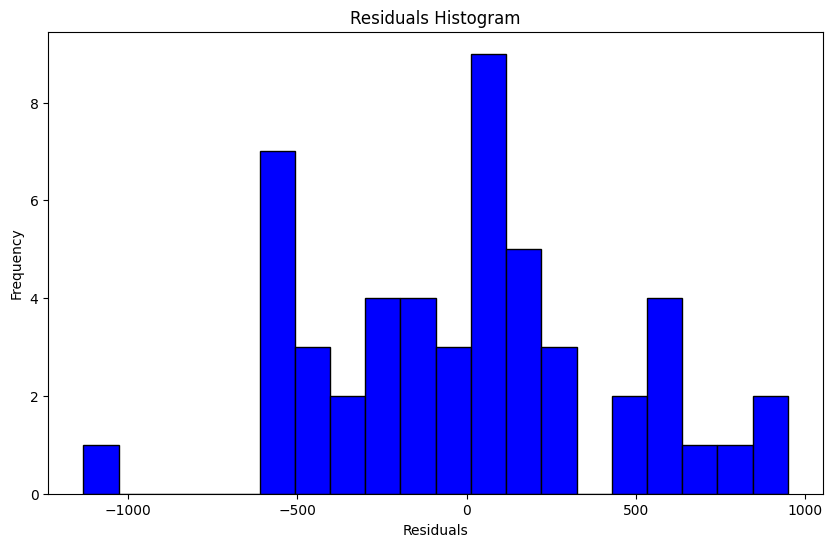

In [6]:
import matplotlib.pyplot as plt

# Plot Residuals Histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='blue', edgecolor='black')
plt.title("Residuals Histogram")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

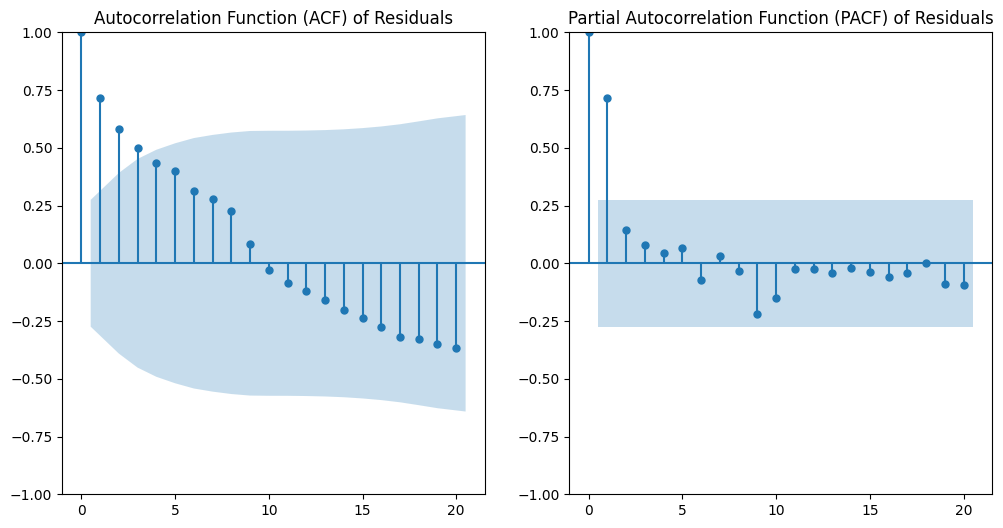

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for Residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# ACF Plot
plot_acf(residuals, lags=20, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF) of Residuals")

# PACF Plot
plot_pacf(residuals, lags=20, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF) of Residuals")

plt.show()

In [8]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X)

# Display results
print("\nBreusch-Pagan Test for Heteroscedasticity:")
print(f"LM Statistic: {bp_test[0]}")
print(f"p-value: {bp_test[1]}")


Breusch-Pagan Test for Heteroscedasticity:
LM Statistic: 1.5382680313283665
p-value: 0.21487578942817626


In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model to the residuals
print("Fitting ARIMA(1,0,0) model to residuals...")
arima_model = ARIMA(residuals, order=(1, 0, 0)).fit()

# Display ARIMA model summary
print(arima_model.summary())

Fitting ARIMA(1,0,0) model to residuals...
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   51
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -362.996
Date:                Wed, 18 Dec 2024   AIC                            731.992
Time:                        16:33:02   BIC                            737.788
Sample:                    03-31-2012   HQIC                           734.207
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2818    183.254     -0.007      0.994    -360.452     357.889
ar.L1          0.7258      0.106      6.816      0.000       0.517       0.934
sigma2   

C:\Users\TEJAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\TEJAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\TEJAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


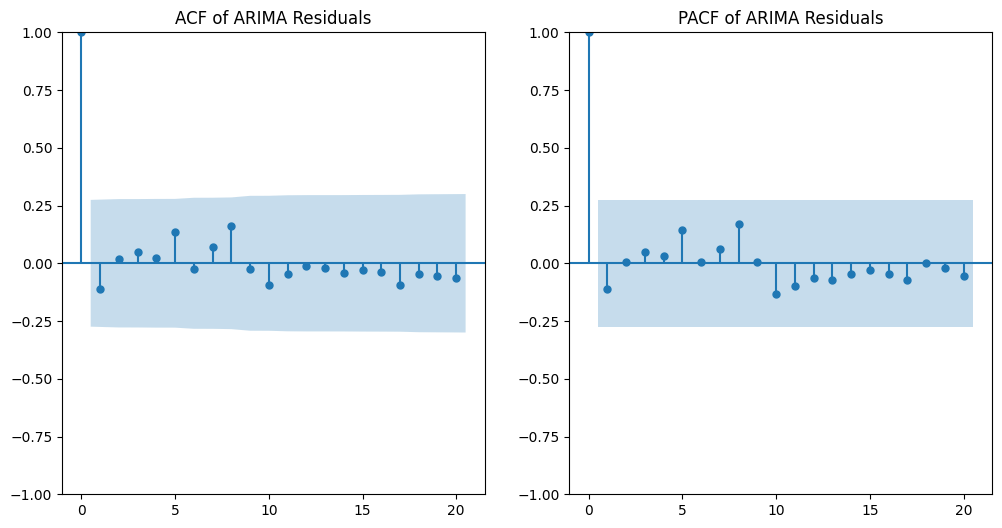

In [10]:
# Extract ARIMA residuals
arima_residuals = arima_model.resid

# Plot ACF and PACF for ARIMA residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(arima_residuals, lags=20, ax=ax[0])
ax[0].set_title("ACF of ARIMA Residuals")

plot_pacf(arima_residuals, lags=20, ax=ax[1])
ax[1].set_title("PACF of ARIMA Residuals")

plt.show()

In [11]:
from arch import arch_model

# Fit GARCH(1,1) model on ARIMA residuals
print("Fitting GARCH(1,1) model to ARIMA residuals...")
garch_model = arch_model(arima_residuals, vol='Garch', p=1, q=1, rescale=False)
garch_results = garch_model.fit(disp='off')

# Display GARCH model summary
print("\nGARCH(1,1) Model Results:")
print(garch_results.summary())

Fitting GARCH(1,1) model to ARIMA residuals...

GARCH(1,1) Model Results:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -353.048
Distribution:                  Normal   AIC:                           714.097
Method:            Maximum Likelihood   BIC:                           721.824
                                        No. Observations:                   51
Date:                Wed, Dec 18 2024   Df Residuals:                       50
Time:                        16:33:02   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------

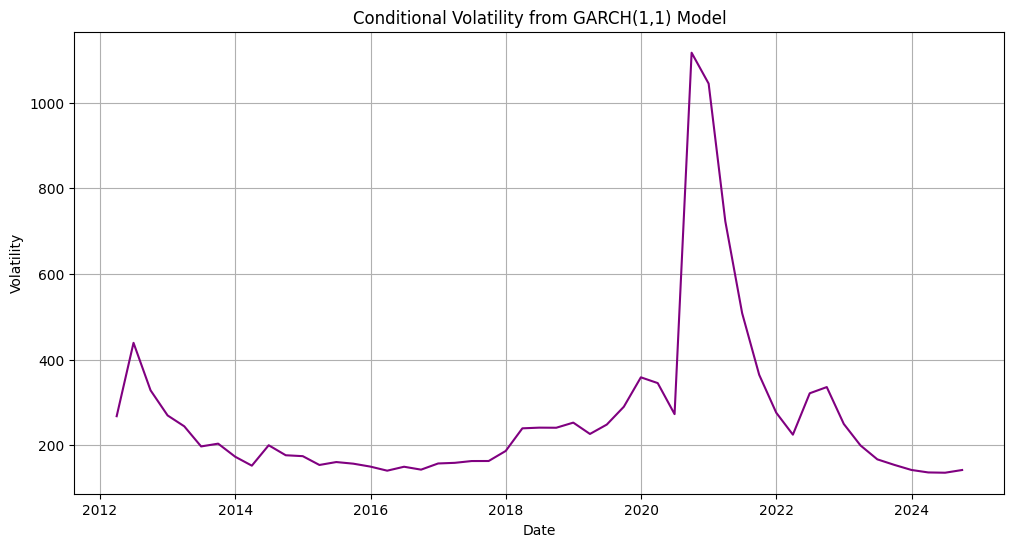

In [12]:
# Plot conditional volatility
plt.figure(figsize=(12, 6))
plt.plot(garch_results.conditional_volatility, color='purple')
plt.title("Conditional Volatility from GARCH(1,1) Model")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid()
plt.show()

In [13]:
# Forecast future volatility
forecast_horizon = 8
garch_forecast = garch_results.forecast(horizon=forecast_horizon)

# Extract forecasted volatility
forecast_volatility = garch_forecast.variance.iloc[-1] ** 0.5
print("\nForecasted Volatility for Next Periods:")
print(forecast_volatility)


Forecasted Volatility for Next Periods:
h.1    151.055597
h.2    178.624774
h.3    202.474261
h.4    223.796432
h.5    243.256776
h.6    261.271651
h.7    278.122081
h.8    294.008348
Name: 2024-09-30 00:00:00, dtype: float64


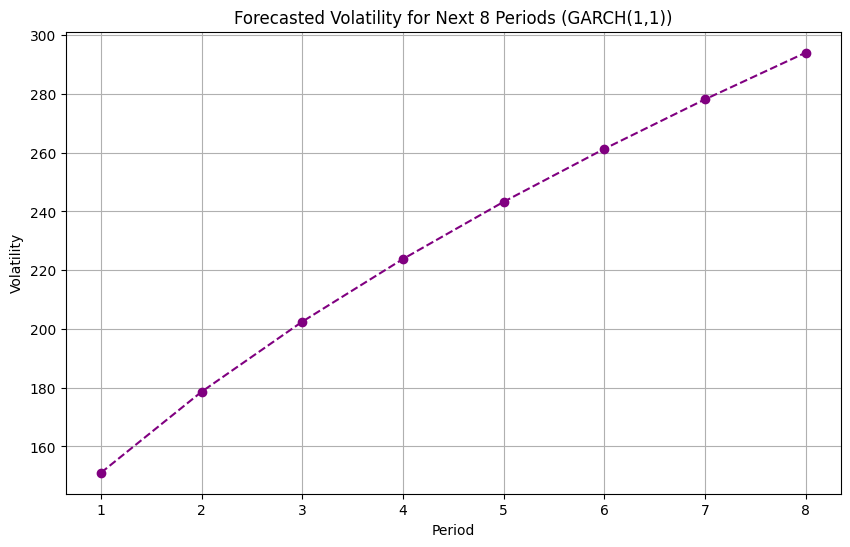

In [14]:
# Forecast future volatility
forecast_horizon = 8
garch_forecast = garch_results.forecast(horizon=forecast_horizon)

# Extract forecasted volatility
forecast_volatility = garch_forecast.variance.iloc[-1] ** 0.5

# Create a plot for forecasted volatility
import matplotlib.pyplot as plt

forecast_periods = range(1, forecast_horizon + 1)
plt.figure(figsize=(10, 6))
plt.plot(forecast_periods, forecast_volatility, marker='o', linestyle='--', color='purple')
plt.title("Forecasted Volatility for Next 8 Periods (GARCH(1,1))")
plt.xlabel("Period")
plt.ylabel("Volatility")
plt.grid()
plt.show()

Forecasting future residuals using ARIMA model...


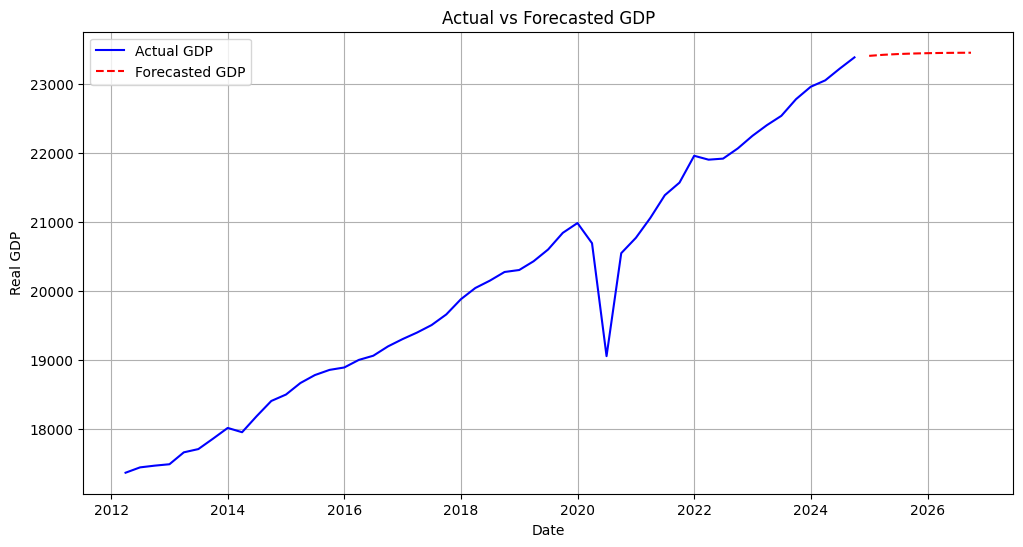

Forecasted GDP values:
             Forecasted_GDP
2024-12-31    23408.444502
2025-03-31    23423.850318
2025-06-30    23434.679722
2025-09-30    23442.187751
2025-12-31    23447.285260
2026-03-31    23450.633311
2026-06-30    23452.711675
2026-09-30    23453.868552


In [15]:
# Forecast GDP for the next 8 quarters (adjust as needed)
forecast_periods = 8

# Forecasting future residuals
print("Forecasting future residuals using ARIMA model...")
forecast_residuals = arima_model.forecast(steps=forecast_periods)

# Add ARIMA residual forecasts back to the predicted GDP (adjusting for mean)
future_index = pd.date_range(data.index[-1], periods=forecast_periods + 1, freq='QE')[1:]
future_gdp = data['Real_GDP'].iloc[-1] + forecast_residuals.cumsum()

# Combine actual and forecasted GDP values
forecast_df = pd.DataFrame({
    'Forecasted_GDP': future_gdp
}, index=future_index)

# Plot Actual and Forecasted GDP
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Real_GDP'], label="Actual GDP", color='blue')
plt.plot(forecast_df.index, forecast_df['Forecasted_GDP'], label="Forecasted GDP", linestyle='--', color='red')
plt.title("Actual vs Forecasted GDP")
plt.xlabel("Date")
plt.ylabel("Real GDP")
plt.legend()
plt.grid()
plt.show()

# Display forecasted GDP values
print("Forecasted GDP values:\n", forecast_df)